Training data loaded successfully.

First five rows of the dataset:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_lt

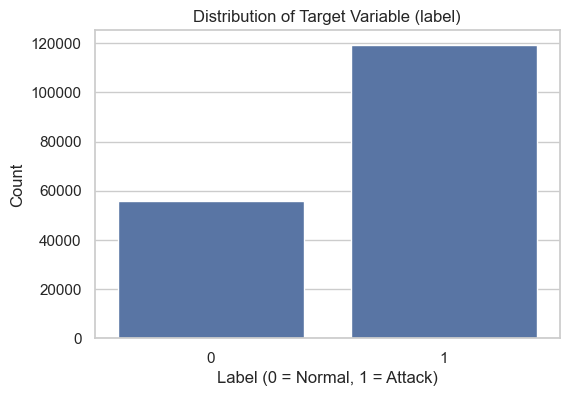

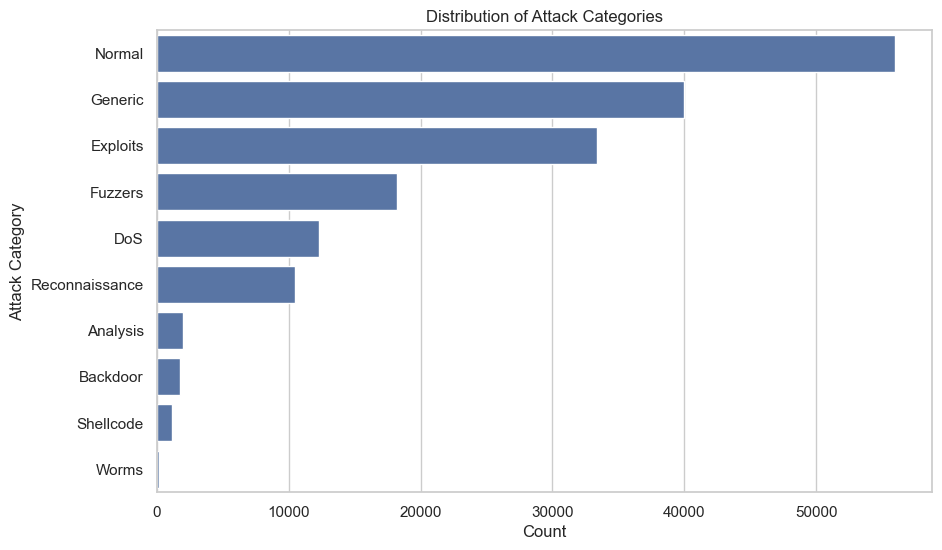


Feature columns:
['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']

Data split into training (140272) and testing (35069) sets.

Training SVM on a subset of data: 10000 samples.

Sampled training set label distribution:
label
1    6806
0    3194
Name: count, dtype: int64

SVM model with class_weight='balanced' trained successfully.


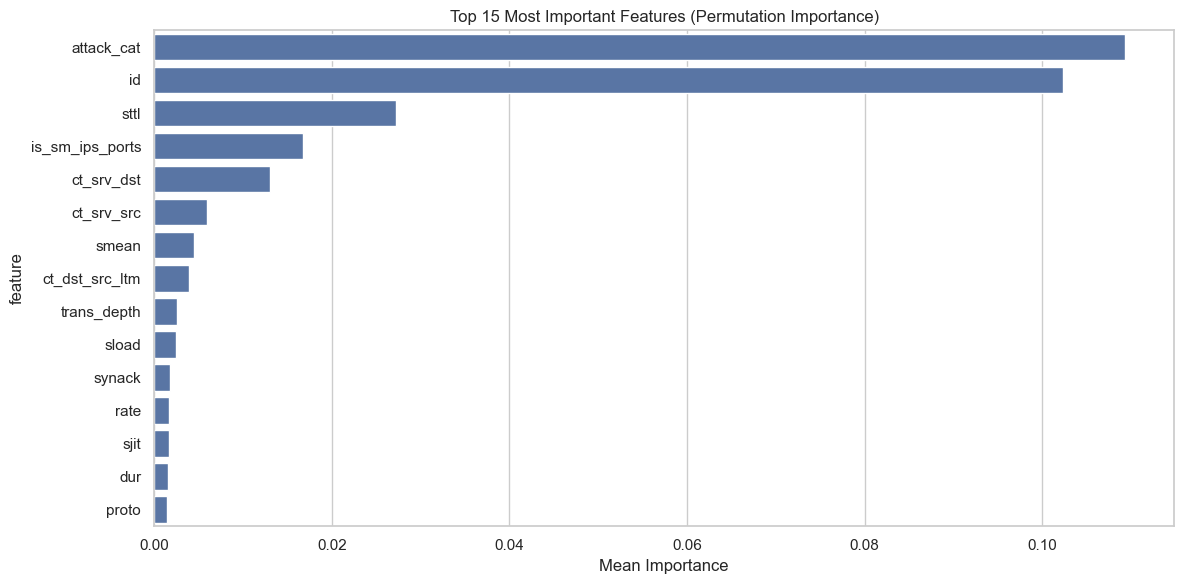


Feature Importance Scores:
              feature  importance       std
43         attack_cat     0.10939  0.001494
0                  id     0.10235  0.002832
10               sttl     0.02721  0.001101
42    is_sm_ips_ports     0.01671  0.000356
41         ct_srv_dst     0.01302  0.000739
31         ct_srv_src     0.00594  0.001014
27              smean     0.00443  0.000424
36     ct_dst_src_ltm     0.00386  0.000892
29        trans_depth     0.00254  0.000377
12              sload     0.00241  0.000217
25             synack     0.00177  0.000628
9                rate     0.00168  0.000183
18               sjit     0.00168  0.000236
1                 dur     0.00155  0.000403
2               proto     0.00142  0.000248
17             dinpkt     0.00138  0.000227
35   ct_dst_sport_ltm     0.00101  0.000375
30  response_body_len     0.00070  0.000237
3             service     0.00038  0.000619
24             tcprtt     0.00038  0.000479
32       ct_state_ttl     0.00038  0.000183
39  

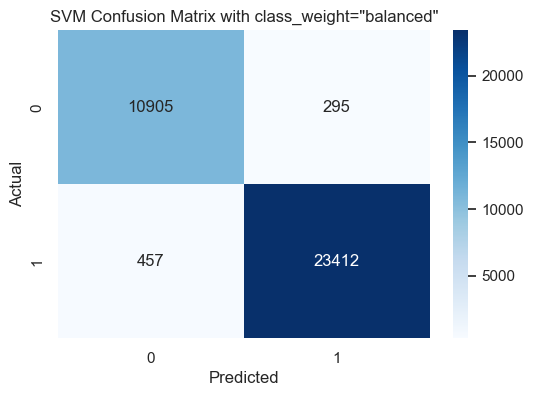

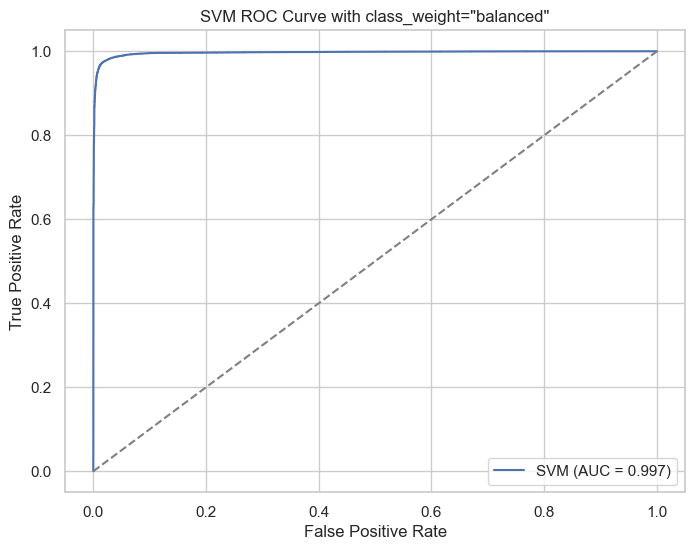


SVM model with class_weight='balanced', scaler, and label encoders saved.

Prediction for sample index 0: 1 (Probability: 1.00)
Training completed in: 0:00:03.577990


In [2]:
# Import Libraries
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

import joblib

# Set Default Styling for Plots
sns.set(style='whitegrid')

# Load the Training Dataset
train_df = pd.read_csv('UNSW_NB15_training-set.csv')
# train_df = pd.read_csv('UNSW_NB15_combined.csv')
print("Training data loaded successfully.")

# Display the First Few Rows of the Dataset
print("\nFirst five rows of the dataset:")
print(train_df.head())

# Get a Summary of the Dataset
print("\nDataset information:")
train_df.info()

# Get Descriptive Statistics
print("\nDescriptive statistics:")
print(train_df.describe().transpose())

# Check for Missing Values
print("\nMissing values in each column:")
print(train_df.isnull().sum())

# Identify Categorical Columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical columns:", categorical_cols)

# Display Unique Values in Categorical Columns
for col in categorical_cols:
    print(f"\nUnique values in '{col}': {train_df[col].unique()}")

# Visualize the Distribution of the Target Variable
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Target Variable (label)')
plt.xlabel('Label (0 = Normal, 1 = Attack)')
plt.ylabel('Count')
plt.show()

# Display the Distribution of Attack Categories
if 'attack_cat' in train_df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y='attack_cat', data=train_df, order=train_df['attack_cat'].value_counts().index)
    plt.title('Distribution of Attack Categories')
    plt.xlabel('Count')
    plt.ylabel('Attack Category')
    plt.show()

# Encode Categorical Variables Using LabelEncoder
le_dict = {}  # Dictionary to Store Label Encoders for Each Categorical Feature
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    le_dict[col] = le  # Save the Label Encoder

# Separate Features and Target Variable
features = train_df.drop(['label'], axis=1)
target = train_df['label']

# Display Feature Names
print("\nFeature columns:")
print(features.columns.tolist())

# Split the Data into Training and Testing Sets
X_train_full, X_test_full, y_train_full, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=42)
print(f"\nData split into training ({len(X_train_full)}) and testing ({len(X_test_full)}) sets.")

# Sample a Subset of the Training Data (10,000 Samples)
sample_size = 10000
X_train_sampled, _, y_train_sampled, _ = train_test_split(
    X_train_full, y_train_full, train_size=sample_size, stratify=y_train_full, random_state=42)

print(f"\nTraining SVM on a subset of data: {X_train_sampled.shape[0]} samples.")

# Check the Distribution of Labels in the Sampled Training Set
print("\nSampled training set label distribution:")
print(y_train_sampled.value_counts())

# Feature Scaling Using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sampled)
X_test_scaled = scaler.transform(X_test_full)

# Initialize the SVM Classifier with Balanced Class Weights
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')

# Record the start time of training
start_time = datetime.now() 

# Train the SVM Model on the Sampled Data
svm_classifier.fit(X_train_scaled, y_train_sampled)
print("\nSVM model with class_weight='balanced' trained successfully.")

# Record the end time of training
end_time = datetime.now()

# Calculate Feature Importance using permutation importance
result = permutation_importance(
    svm_classifier, X_train_scaled, y_train_sampled,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create a DataFrame of feature importances
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
})

# Sort features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features (Permutation Importance)')
plt.xlabel('Mean Importance')
plt.tight_layout()
plt.show()

# Print feature importance scores
print("\nFeature Importance Scores:")
print(feature_importance)

# Make Predictions on the Test Set
svm_predictions = svm_classifier.predict(X_test_scaled)

# Evaluate the Model
print("\nSVM Classifier Report with class_weight='balanced':")
print(classification_report(y_test, svm_predictions))

# Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix with class_weight="balanced"')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
svm_probs = svm_classifier.predict_proba(X_test_scaled)[:, 1]
svm_auc = roc_auc_score(y_test, svm_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

plt.figure(figsize=(8, 6))
plt.plot(svm_fpr, svm_tpr, label='SVM (AUC = {:.3f})'.format(svm_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('SVM ROC Curve with class_weight="balanced"')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Save the Trained SVM Model, Scaler, and Label Encoders
joblib.dump(svm_classifier, 'svm_model_balanced.joblib')
joblib.dump(scaler, 'scaler_balanced.joblib')
joblib.dump(le_dict, 'label_encoders_balanced.joblib')
print("\nSVM model with class_weight='balanced', scaler, and label encoders saved.")

# Function to Simulate Detection on New Data
def detect_intrusions(model, scaler, le_dict, data_row):
    # Preprocess the Data Row (Assuming It Has the Same Structure)
    data_row_encoded = data_row.copy()

    # If 'data_row_encoded' Is a Series, Convert It to a DataFrame
    if isinstance(data_row_encoded, pd.Series):
        data_row_encoded = data_row_encoded.to_frame().T
    else:
        data_row_encoded = data_row_encoded.copy()

    # Encode Categorical Variables Using the Saved Label Encoders
    for col in categorical_cols:
        le = le_dict[col]
        value = data_row_encoded[col].iloc[0]
        # Convert Value to String
        value_str = str(value)

        if value_str in le.classes_:
            data_row_encoded[col] = le.transform([value_str])[0]
        else:
            # Handle Unseen Categories by Assigning a Default Value (e.g., Most Frequent Category)
            data_row_encoded[col] = le.transform([le.classes_[0]])[0]

    # Drop the Target Variable If Present
    if 'label' in data_row_encoded.columns:
        data_row_encoded = data_row_encoded.drop(['label'], axis=1)

    # Ensure the Columns Are in the Same Order as the Training Data
    data_row_encoded = data_row_encoded.reindex(columns=features.columns, fill_value=0)

    # Scale the Features
    data_row_scaled = scaler.transform(data_row_encoded)

    # Predict
    prediction = model.predict(data_row_scaled)
    probability = model.predict_proba(data_row_scaled)[0][1]

    return prediction[0], probability

# Example Usage with a Sample from the Test Set
sample_index = 0  # You Can Change This Index to Test Different Samples

# Get the Raw Sample Data from the Test Set as a DataFrame and Make a Copy
sample_data_raw = X_test_full.iloc[[sample_index]].copy()
sample_data_raw['label'] = y_test.iloc[sample_index]

# Use the detect_intrusions Function to Process and Predict
prediction, probability = detect_intrusions(svm_classifier, scaler, le_dict, sample_data_raw)
print(f"\nPrediction for sample index {sample_index}: {prediction} (Probability: {probability:.2f})")

# Calculate and print the training duration
training_duration = end_time - start_time
print(f"Training completed in: {training_duration}")